In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import cv2

def preprocess_underwater(img_bgr, gamma=0.9, clipLimit=2.0, tileGridSize=(8,8)):

    img = img_bgr.astype(np.float32)
    avg_b = np.mean(img[:,:,0])
    avg_g = np.mean(img[:,:,1])
    avg_r = np.mean(img[:,:,2])
    avg_gray = (avg_b + avg_g + avg_r) / 3
    
    img[:,:,0] *= (avg_gray / (avg_b + 1e-6))
    img[:,:,1] *= (avg_gray / (avg_g + 1e-6))
    img[:,:,2] *= (avg_gray / (avg_r + 1e-6))
    img = np.clip(img, 0, 255).astype(np.uint8)

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    l_clahe = clahe.apply(l)
    lab = cv2.merge((l_clahe, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(256)]).astype("uint8")
    img = cv2.LUT(img, table)

    return img


def batch_preprocess(input_dir, output_dir, gamma=0.9, clipLimit=2.0, tileGridSize=(8,8)):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    supported_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

    for root, _, files in os.walk(input_dir):
        for fname in files:
            ext = os.path.splitext(fname)[1].lower()
            if ext not in supported_exts:
                continue

            in_path = os.path.join(root, fname)
            rel_path = os.path.relpath(in_path, input_dir)
            out_path = os.path.join(output_dir, rel_path)

            os.makedirs(os.path.dirname(out_path), exist_ok=True)

            img = cv2.imread(in_path)
            if img is None:
                continue

            processed = preprocess_underwater(img, gamma, clipLimit, tileGridSize)
            cv2.imwrite(out_path, processed)





In [3]:
batch_preprocess("/kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI/GT", "/kaggle/working/pre_img", gamma=0.9, clipLimit=2.0, tileGridSize=(8,8))


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms, utils as vutils
from PIL import Image

In [5]:
device = torch.device("cuda" if True else "cpu")

In [6]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.img_paths = [os.path.join(root_dir, fname)
                          for fname in os.listdir(root_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


In [7]:
transform = transforms.Compose([
    transforms.Resize([192,320]),
    transforms.ToTensor()
])


In [8]:
dataset = CustomDataset(
    root_dir="/kaggle/working/pre_img",
    transform=transform
)


In [9]:
from torch.utils.data import random_split, DataLoader


In [10]:
total_size = len(dataset)
test_size = int(0.1 * total_size)
train_size = total_size - test_size


In [11]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [12]:
dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

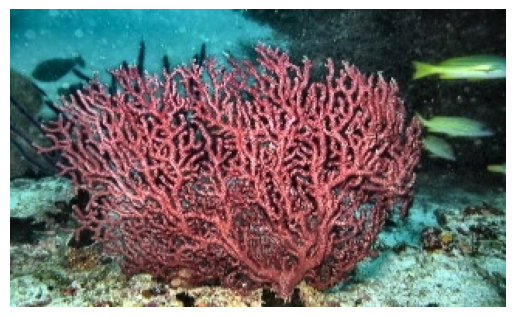

In [13]:
import matplotlib.pyplot as plt
for img in dataloader:
    i=img[0].permute(1,2,0)
    i=i.numpy()

    plt.imshow(i)
    plt.axis("off")
    plt.show()
    break

In [14]:
class res_block(nn.Module):
    def __init__(self,c):
        super().__init__()
        self.block=nn.Sequential(
            nn.Conv2d(c,c,3,1,1),
            nn.BatchNorm2d(c),
            nn.LeakyReLU(0.02),

            nn.Conv2d(c,c,3,1,1),
            nn.LeakyReLU(0.02)
        )
    def forward(self,x):
        return x+self.block(x)

In [15]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(
            nn.Conv2d(3,64,4,2,1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(64),

            nn.Conv2d(64,128,4,2,1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(128),

            nn.Conv2d(128,128,3,1,1),
            nn.LeakyReLU(0.02))
        
        self.res1=res_block(128)

        self.maxi=nn.MaxPool2d(2,2)

        self.net_2=nn.Sequential(
            nn.Conv2d(128,64,3,1,1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(64),

            nn.Conv2d(64,64,3,1,1),

            nn.Conv2d(64,64,3,1,1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(64))
        
        self.res2=res_block(64)

        self.final=nn.Conv2d(64,16,3,1,1)
        
    def forward(self,x):
        x=self.net(x)
        x=self.res1(x)
        x=self.maxi(x)
        x=self.net_2(x)
        x=self.res2(x)
        return self.final(x)

In [16]:
class embeddings(nn.Module):
    def __init__(self,num_embeddings,embedding_dim,commitment_cost=0.25):
        super().__init__()
        self.num_embeddings=num_embeddings
        self.embedding_dim=embedding_dim
        self.commitment_cost=commitment_cost

        self.embedding=nn.Embedding(self.num_embeddings,self.embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)

    def forward(self,z):
        b,d,h,w=z.shape
        z_flattened=z.permute(0,2,3,1).contiguous()
        z_flattened=z_flattened.view(-1,d)

        distances = (
            torch.sum(z_flattened**2, dim=1, keepdim=True) +
            torch.sum(self.embedding.weight**2, dim=1) -
            2 * torch.matmul(z_flattened, self.embedding.weight.t())
        )

        indices = torch.argmin(distances, dim=1)
        quantized = self.embedding(indices)
        quantized = quantized.view(b, h, w, d).permute(0, 3, 1, 2).contiguous()

        e_latent_loss = F.mse_loss(quantized.detach(), z)
        q_latent_loss = F.mse_loss(quantized, z.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        quantized = z + (quantized - z).detach()

        avg_probs = torch.histc(
            indices.float(), bins=self.num_embeddings, min=0, max=self.num_embeddings-1
        ) / indices.numel()
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        return quantized, indices, loss, perplexity


In [17]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(

            nn.Conv2d(16, 32, 3, 1, 1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(32),

            nn.Conv2d(32,64,3,1,1),
            nn.LeakyReLU(0.02),

            nn.Conv2d(64,64,3,1,1),
            nn.LeakyReLU(0.02),

            
            nn.ConvTranspose2d(64, 128, 4, 2, 1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(128),

            
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.LeakyReLU(0.02),

            
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(64),

            nn.Conv2d(64,64,3,1,1),
            nn.LeakyReLU(0.02),

            nn.Conv2d(64,64,3,1,1),
            nn.LeakyReLU(0.02),

            
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 16, 3, 1, 1),
            nn.LeakyReLU(0.02),

            nn.Conv2d(16,3,3,1,1),
            nn.LeakyReLU(0.02),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [18]:
class Model(nn.Module):
    def __init__(self, Encoder, Codebook, Decoder):
        super().__init__()
        self.encoder = Encoder
        self.codebook = Codebook
        self.decoder = Decoder
        
    def forward(self,x):
        z=self.encoder(x)
        quantized, indices, loss, perplexity=self.codebook(z)
        x_hat = self.decoder(quantized)
        return x_hat,loss,perplexity

In [19]:
encoder=Encoder()
codebook=embeddings(2048,16)
decoder=Decoder()
model=Model(encoder,codebook,decoder).to(device)

In [20]:
import torchvision.models as models

class PerceptualLoss(nn.Module):
    def __init__(self, layer_ids=[3, 8, 17], use_normalize=True):
        super().__init__()
        vgg = models.vgg19(pretrained=True).features.eval()

        self.vgg = nn.Sequential(*list(vgg.children())[:max(layer_ids)+1])
        for p in self.vgg.parameters():
            p.requires_grad = False 

        self.layer_ids = layer_ids
        self.use_normalize = use_normalize

    def forward(self, x, y):
        loss = 0.0
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            y = layer(y)
            if i in self.layer_ids:
                if self.use_normalize:
                    loss += torch.mean((self._normalize(x) - self._normalize(y))**2)
                else:
                    loss += torch.mean((x - y)**2)
        return loss

    def _normalize(self, feat):
        norm = torch.sqrt(torch.sum(feat**2, dim=1, keepdim=True) + 1e-6)
        return feat / norm


In [21]:
from torch.optim import Adam


mse_loss = nn.MSELoss()
perc_loss = PerceptualLoss(layer_ids=[3, 8, 17]).to(device)

optimizer = Adam(model.parameters(), lr=2.5e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 219MB/s] 


In [22]:
for epoch in range(75):
    overall_loss = 0.0
    for batch_idx, x in enumerate(dataloader):
        x = x.to(device)

        optimizer.zero_grad()

        x_hat, c_loss, perplexity = model(x)
        recon_loss = mse_loss(x_hat, x)
        p_loss=perc_loss(x,x_hat)
        
        loss = recon_loss + c_loss + 0.2*(p_loss)
                
        loss.backward()
        optimizer.step()    

        overall_loss += loss.item()  

    avg_loss = overall_loss / len(dataloader)  
    print(f"Epoch [{epoch+1}/75], Loss: {avg_loss:.4f} , perplexity : {perplexity:.4f}")

print("Finish!!")


Epoch [1/75], Loss: 1.2801 , perplexity : 67.4245
Epoch [2/75], Loss: 0.2370 , perplexity : 46.4651
Epoch [3/75], Loss: 0.1449 , perplexity : 36.8973
Epoch [4/75], Loss: 0.1215 , perplexity : 35.7418
Epoch [5/75], Loss: 0.0994 , perplexity : 37.2536
Epoch [6/75], Loss: 0.0848 , perplexity : 38.4298
Epoch [7/75], Loss: 0.0741 , perplexity : 39.1580
Epoch [8/75], Loss: 0.0674 , perplexity : 41.3228
Epoch [9/75], Loss: 0.0627 , perplexity : 41.4210
Epoch [10/75], Loss: 0.0589 , perplexity : 42.6420
Epoch [11/75], Loss: 0.0563 , perplexity : 43.9159
Epoch [12/75], Loss: 0.0540 , perplexity : 47.9573
Epoch [13/75], Loss: 0.0519 , perplexity : 51.5193
Epoch [14/75], Loss: 0.0494 , perplexity : 49.9243
Epoch [15/75], Loss: 0.0467 , perplexity : 55.7820
Epoch [16/75], Loss: 0.0443 , perplexity : 56.6358
Epoch [17/75], Loss: 0.0423 , perplexity : 59.9045
Epoch [18/75], Loss: 0.0405 , perplexity : 58.0144
Epoch [19/75], Loss: 0.0381 , perplexity : 64.0358
Epoch [20/75], Loss: 0.0367 , perplexity

In [23]:
import matplotlib.pyplot as plt


In [24]:
def draw_sample_image(x, postfix):
  
    plt.figure(figsize=(16,16))
    plt.axis("off")
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))


In [25]:
from torchvision.utils import save_image, make_grid


In [26]:
model.eval()

with torch.no_grad():

    for batch_idx, (x) in enumerate((test_loader)):

        x = x.to(device)
        x_hat, loss, perplexity = model(x)
        break


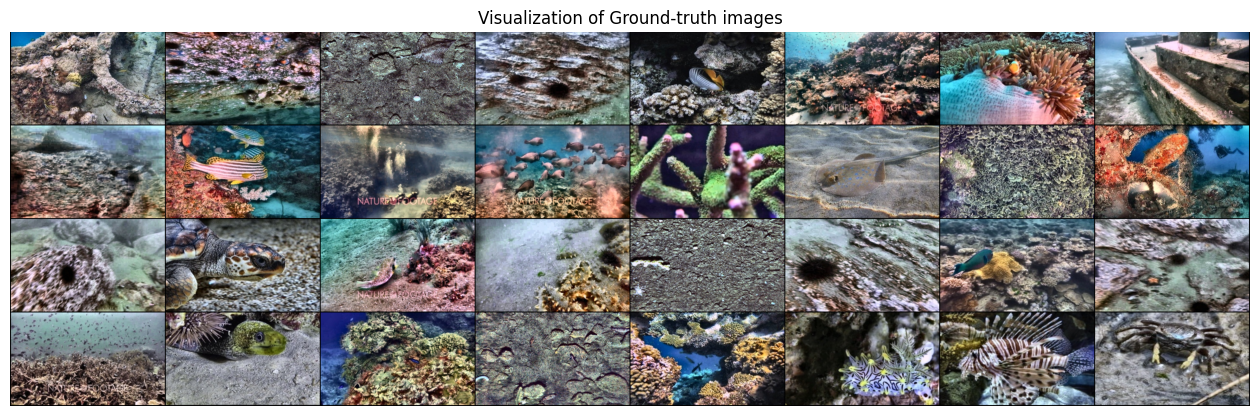

In [27]:
draw_sample_image(x[:64//2], "Ground-truth images")

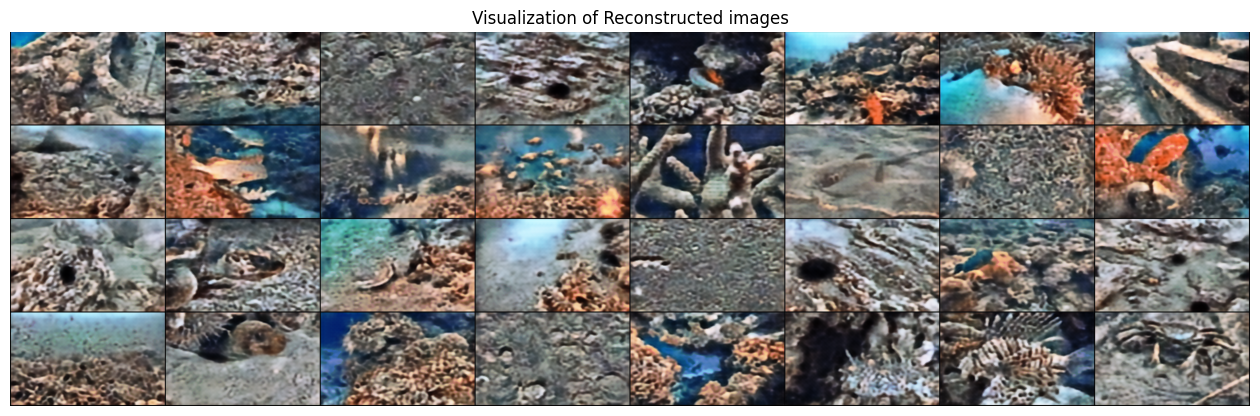

In [28]:
draw_sample_image(x_hat[:64//2], "Reconstructed images")

- input size = 3 * 192 * 320 * 8 = 14,74,560

- encoder output = 16,24,40
- code book size = 2048,16

number of bits after compression : 

- 24 * 40 * ciel(log2(2048)) = 10,560

compression ratio = 14,74,560 / 10,560 = 139.63636